# Solution: Extending your model to 3 age groups

## Option 1: define all age groups individually

One option to write this code for a model with 3 age groups is to proceed like in the previous etivity and define all age-specific compartments (S1, I1, R1, S2, I2, R2, S3, I3 and R3) and contact parameters ($c_{11}$, $c_{12}$, $c_{13}$, $c_{21}$, $c_{22}$, $c_{23}$, $c_{31}$, $c_{32}$ ad $c_{33}$) individually. The code for this would look as follows:

Loading required package: deSolve
Loading required package: reshape2
Loading required package: ggplot2


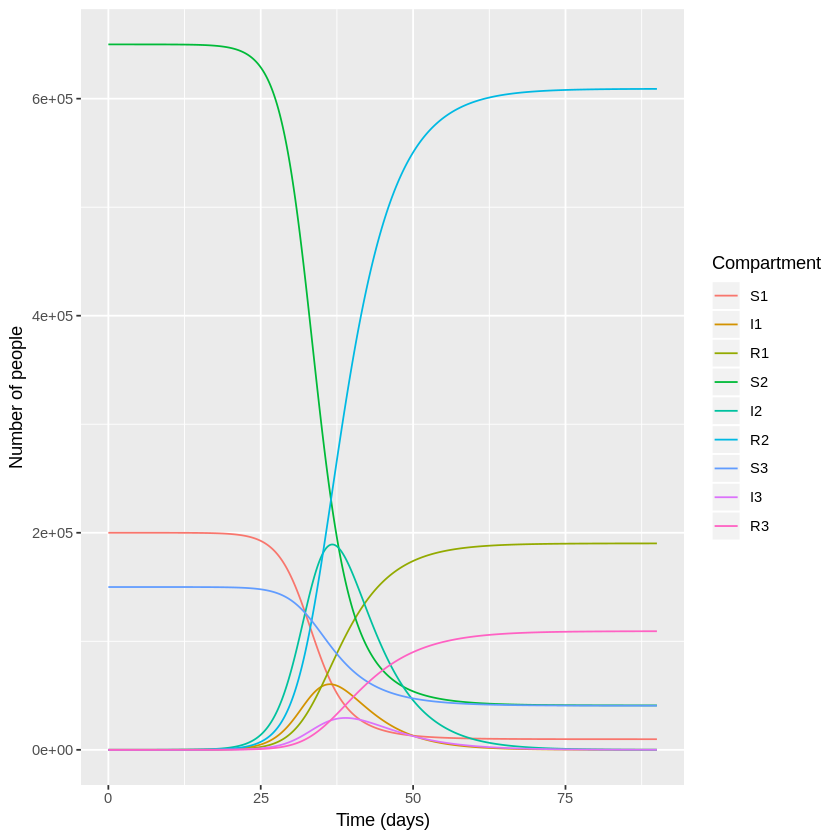

In [1]:
# PACKAGES
require(deSolve)
require(reshape2)
require(ggplot2)

# INPUT
# Initial state values for a naive population (everyone is susceptible except for 1 index case),
# where the total population size N is (approximately) 1 million, 20% of this are children and 15% are elderly
initial_state_values <- c(S1 = 200000,   # 20% of the population are children - all susceptible
                          I1 = 1,        # the outbreak starts with 1 infected person (can be of either age)  
                          R1 = 0,
                          S2 = 650000,   # 100%-20%-15% of the population are adults - all susceptible
                          I2 = 0,
                          R2 = 0,
                          S3 = 150000,   # 15% of the population are elderly - all susceptible
                          I3 = 0,
                          R3 = 0)

# Parameters
parameters <- c(b = 0.05,     # the probability of infection per contact is 5%
                c_11 = 7,     # daily number of contacts that children make with each other
                c_12 = 5,     # daily number of contacts that children make with adults
                c_13 = 1,     # daily number of contacts that children make with the elderly
                c_21 = 2,     # daily number of contacts that adults make with children
                c_22 = 9,     # daily number of contacts that adults make with each other
                c_23 = 1,     # daily number of contacts that adults make with the elderly
                c_31 = 1,     # daily number of contacts that elderly people make with children
                c_32 = 3,     # daily number of contacts that elderly people make with adults
                c_33 = 2,     # daily number of contacts that elderly people make with each other
                gamma = 1/5)  # the rate of recovery is 1/5 per day

# Run simulation for 3 months
times <- seq(from = 0, to = 90, by = 0.1)

# MODEL FUNCTION
sir_age_model <- function(time, state, parameters) {  
  
  with(as.list(c(state, parameters)), {
    
    N1 <- S1+I1+R1  # the total number of children in the population
    N2 <- S2+I2+R2  # the total number of adults in the population
    N3 <- S3+I3+R3  # the total number of elderly people in the population  
    
    # Defining the force of infection
      
    # For each age group, need to add the infection rate due to contact with the elderly, 
    # and need to define add an equation for the force of infection experienced by the elderly
    
    # Force of infection acting on susceptible children:
    lambda_1 <- b * c_11 * I1/N1 + b * c_12 * I2/N2 + b * c_13 * I3/N3
    # Force of infection acting on susceptible adults:
    lambda_2 <- b * c_21 * I1/N1 + b * c_22 * I2/N2 + b * c_23 * I3/N3  
    # Force of infection acting on susceptible elderly people:
    lambda_3 <- b * c_31 * I1/N1 + b * c_32 * I2/N2 + b * c_33 * I3/N3  
    
    # The differential equations
    # Rate of change in children:
    dS1 <- -lambda_1 * S1               
    dI1 <- lambda_1 * S1 - gamma * I1
    dR1 <- gamma * I1
    # Rate of change in adults:
    dS2 <- -lambda_2 * S2            
    dI2 <- lambda_2 * S2 - gamma * I2
    dR2 <- gamma * I2   
    # Rate of change in the elderly:
    dS3 <- -lambda_3 * S3            
    dI3 <- lambda_3 * S3 - gamma * I3
    dR3 <- gamma * I3 
    
    # Output
    return(list(c(dS1, dI1, dR1, dS2, dI2, dR2, dS3, dI3, dR3))) 
  })
}
    
    
# MODEL OUTPUT

output <- as.data.frame(ode(y = initial_state_values, 
                            times = times, 
                            func = sir_age_model,
                            parms = parameters))

# Turn output into long format
output_long <- melt(as.data.frame(output), id = "time") 

# Plot number of people in all compartments over time
ggplot(data = output_long,                                               
       aes(x = time, y = value, colour = variable, group = variable)) +  
  geom_line() +                                                          
  xlab("Time (days)")+                                                   
  ylab("Number of people") +                                
  labs(colour = "Compartment") 

### How many infections occurred in each age group over the course of the epidemic, and what proportion of children, adults and elderly individuals does this represent? How does this compare to your result from the previous etivity?

In [2]:
print("Cumulative incidence in children:")
output$S1[1]-output$S1[nrow(output)]
print("Cumulative incidence in adults:")
output$S2[1]-output$S2[nrow(output)]
print("Cumulative incidence in the elderly:")
output$S3[1]-output$S3[nrow(output)]

[1] "Cumulative incidence in children:"


[1] 190215.4

[1] "Cumulative incidence in adults:"


[1] 609095.5

[1] "Cumulative incidence in the elderly:"


[1] 109311.1

190,215 children, 609,095 adults and 109,311 elderly people were infected over the course of this outbreak. Dividing these by the age-specific population sizes of 200,000, 650,000 and 150,000, the model predicts that 95% of children, 94% of adults and 73% of the elderly in this population would be infected in this epidemic.

As you can see, a smaller proportion of elderly people are infected than the population of children or adults, but we were unable to observe this with our previous model because we did not stratify the model in as much detail with regards to age. Instead, we only observed the average epidemiological pattern in all adults.

## Option 2: a scalable approach

The previous approach worked well for this example of an age-structured model because we only have a few age groups, and is easy to understand when reading the code. However, what if we have more than 3 age groups? For example, what if we want to have separate compartments for every 1 year of life? Writing out all compartments and parameters separately quickly becomes repetitive and even unfeasible, so it is useful to familiarise yourself with an approach that can be scaled up to as many strata as you want to include.

The main difference in the code below is that we define S, I and R compartments as **vectors** within the model function, each of length 3 for the 3 age groups. R executes any command we apply to each element of the vector separately, allowing us to write out the differential equations only once for each epidemiological compartment (S, I, R). One consequence of this is that we have to reorder the initial states vector, into the order: susceptible children, susceptible adults, susceptible elderly, infected children, infected adults, etc.

We can then define the age-specific contact pattern as a matrix. When calculating the force of infection, we multiply the contact matrix with the vector of the proportion of infected people for each age group, giving us 3 age-specific forces of infection stored in the "lambda" vector.

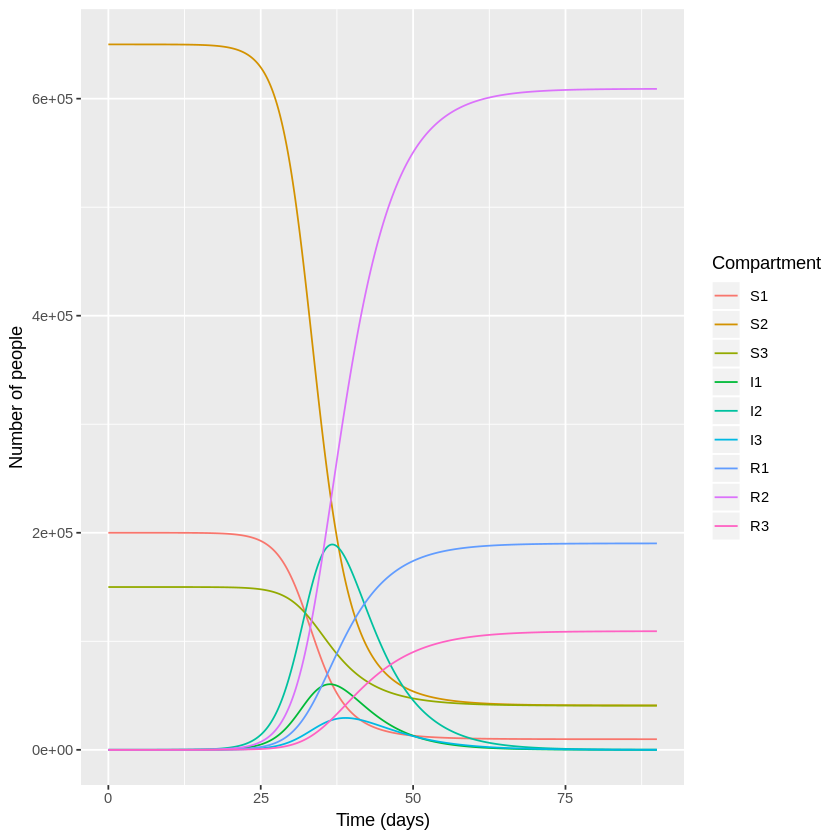

In [3]:
# INPUT
# Initial state values for a naive population (everyone is susceptible except for 1 index case),
# where the total population size N is (approximately) 1 million, 20% of this are children and 15% are elderly
initial_state_values <- c(S1 = 200000,   # 20% of the population are children - all susceptible
                          S2 = 650000,   # 100%-20%-15% of the population are adults - all susceptible
                          S3 = 150000,   # 15% of the population are elderly - all susceptible
                          I1 = 1,        # the outbreak starts with 1 infected person (can be of either age) 
                          I2 = 0,
                          I3 = 0,
                          R1 = 0,
                          R2 = 0,   
                          R3 = 0)

# Set up an empty contact matrix with rows for each age group and columns for each age group
contact_matrix <- matrix(0,nrow=3,ncol=3)
# Fill in the contract matrix
contact_matrix[1,1] = 7     # daily number of contacts that children make with each other
contact_matrix[1,2] = 5     # daily number of contacts that children make with adults
contact_matrix[1,3] = 1     # daily number of contacts that children make with the elderly
contact_matrix[2,1] = 2     # daily number of contacts that adults make with children
contact_matrix[2,2] = 9     # daily number of contacts that adults make with each other
contact_matrix[2,3] = 1     # daily number of contacts that adults make with the elderly
contact_matrix[3,1] = 1     # daily number of contacts that elderly people make with children
contact_matrix[3,2] = 3     # daily number of contacts that elderly people make with adults
contact_matrix[3,3] = 2     # daily number of contacts that elderly people make with each other
# The contact_matrix now looks exactly like the one in the etivity instructions. We add this matrix as a parameter below.

# Parameters
parameters <- c(b = 0.05,     # the probability of infection per contact is 5%
                contact_matrix = contact_matrix,   # the age-specific average number of daily contacts (defined above)
                gamma = 1/5)  # the rate of recovery is 1/5 per day

# Run simulation for 3 months
times <- seq(from = 0, to = 90, by = 0.1)

# MODEL FUNCTION
sir_age_model <- function(time, state, parameters) {  
  
  with(as.list(parameters), {
    
    n_agegroups <- 3                                 # number of age groups
    S <- state[1:n_agegroups]                        # assign to S the first 3 numbers in the initial_state_values vector
    I <- state[(n_agegroups+1):(2*n_agegroups)]      # assign to I numbers 4 to 6 in the initial_state_values vector
    R <- state[(2*n_agegroups+1):(3*n_agegroups)]    # assign to R numbers 7 to 9 in the initial_state_values vector
      
    N <- S+I+R     # people in S, I and R are added separately by age group, so N is also a vector of length 3
    
    # Defining the force of infection
      
    # Force of infection acting on susceptible children
    lambda <- b * contact_matrix %*% as.matrix(I/N) 
    # %*% is used to multiply matrices in R
    # the lambda vector contains the forces of infection for children, adults and the elderly (length 3)

    # The differential equations
    # Rate of change in children:
    dS <- -lambda * S             
    dI <- lambda * S - gamma * I
    dR <- gamma * I
    
    # Output
    return(list(c(dS, dI, dR))) 
  })
}
    
    
# MODEL OUTPUT

output <- as.data.frame(ode(y = initial_state_values, 
                            times = times, 
                            func = sir_age_model,
                            parms = parameters))
# the output column names are adopted from the names we assigned in the initial_state_values vector

# Turn output into long format
output_long <- melt(as.data.frame(output), id = "time") 

# Plot number of people in all compartments over time
ggplot(data = output_long,                                               
       aes(x = time, y = value, colour = variable, group = variable)) +  
  geom_line() +                                                          
  xlab("Time (days)")+                                                   
  ylab("Number of people") +                                
  labs(colour = "Compartment") 